In [18]:
def lstm(dataframe):
    dataframe = lib_copy.fetch_ohlcv(ticker_symbol)

    def adding_boll_kelt_ewma_dataframe(dataframe):
        lib_copy.bollinger_band_generator(dataframe)
        lib_copy.keltner_channel(dataframe)
        lib_copy.ewma(dataframe)

        return dataframe

    everything = adding_boll_kelt_ewma_dataframe(dataframe)

    everything = df.dropna()

    response_data = lib_copy.signals_generator(everything)

    response_data.index = response_data.index.date
    final_df = response_data

    X = final_df.iloc[:, 0:20].values
    
    y = final_df.iloc[:, -1].values

    X, y = np.array(X), np.array(y).reshape(-1,1)

    # Manually splitting the data
    split = int(0.7 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]

    # Importing the MinMaxScaler from sklearn
    from sklearn.preprocessing import MinMaxScaler

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    # Importing required Keras modules
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout

    # Define the LSTM RNN model.
    model = Sequential()

    # Initial model setup
    number_units = 30
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Train the model
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

    # Make predictions using the testing data X_test
    predicted = model.predict(X_test)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Create a DataFrame of Real and Predicted values
    comparison = pd.DataFrame({
        "Actual": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index = final_df.index[-len(real_prices): ]) 

    return model.summary(), model.evaluate(X_test, y_test, verbose=0), comparison.plot()

In [20]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
%matplotlib inline

In [21]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8


True

In [22]:


df = lib_copy.fetch_ohlcv("TSLA")


In [23]:
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

In [24]:
everything = adding_boll_kelt_ewma_dataframe(df)

In [25]:
# Looking for missing values
everything.isnull().sum().sum()

61

In [26]:
# Filling missing values with the previous ones
everything = df.dropna()
everything.head()

,open,high,low,close,volume,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,close_-1_s,tr,tr_14_smma,atr,kcmid,kcup,kclo,EMA9,EMA21
2020-01-03 08:30:00-05:00,439.630,439.89,436.120,436.120,3571,429.21550,3.329131,435.873761,422.557239,438.010,3.770,2.828504,2.828504,429.21550,432.044004,426.386996,430.818076,429.352575
2020-01-03 08:45:00-05:00,435.400,438.60,435.400,436.990,956,429.75000,3.676440,437.102880,422.397120,436.120,3.200,2.862839,2.862839,429.75000,432.612839,426.887161,432.052461,430.046886
2020-01-03 09:00:00-05:00,438.475,441.43,437.510,441.430,2592,430.49850,4.420057,439.338615,421.658385,436.990,4.440,3.005606,3.005606,430.49850,433.504106,427.492894,433.927969,431.081715
2020-01-03 09:15:00-05:00,440.450,440.45,440.241,440.241,369,431.10405,4.883775,440.871600,421.336500,441.430,1.189,2.844245,2.844245,431.10405,433.948295,428.259805,435.190575,431.914377
2020-01-03 09:30:00-05:00,440.240,454.00,437.050,450.300,107506,432.20405,6.446524,445.097098,419.311002,440.241,16.950,4.075772,4.075772,432.20405,436.279822,428.128278,438.212460,433.585797


In [27]:
response_data = lib_copy.signals_generator(everything)

response_data.index = response_data.index.date
final_df = response_data
final_df.head()

,open,high,low,close,volume,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,close_-1_s,...,tr_14_smma,atr,kcmid,kcup,kclo,EMA9,EMA21,squeeze,crossover,target
2020-01-03,439.630,439.89,436.120,436.120,3571,429.21550,3.329131,435.873761,422.557239,438.010,...,2.828504,2.828504,429.21550,432.044004,426.386996,430.818076,429.352575,0.0,0.0,0.0
2020-01-03,435.400,438.60,435.400,436.990,956,429.75000,3.676440,437.102880,422.397120,436.120,...,2.862839,2.862839,429.75000,432.612839,426.887161,432.052461,430.046886,0.0,0.0,0.0
2020-01-03,438.475,441.43,437.510,441.430,2592,430.49850,4.420057,439.338615,421.658385,436.990,...,3.005606,3.005606,430.49850,433.504106,427.492894,433.927969,431.081715,0.0,0.0,0.0
2020-01-03,440.450,440.45,440.241,440.241,369,431.10405,4.883775,440.871600,421.336500,441.430,...,2.844245,2.844245,431.10405,433.948295,428.259805,435.190575,431.914377,0.0,0.0,0.0
2020-01-03,440.240,454.00,437.050,450.300,107506,432.20405,6.446524,445.097098,419.311002,440.241,...,4.075772,4.075772,432.20405,436.279822,428.128278,438.212460,433.585797,0.0,0.0,0.0


In [28]:
X = final_df.iloc[:, 0:20].values
y = final_df.iloc[:, -1].values

X, y = np.array(X), np.array(y).reshape(-1,1)

In [29]:
print (f"X sample values:\n{X[:3]} \n")
print (f"X sample values:\n{y[:3]} \n")


X sample values:
[[4.39630000e+02 4.39890000e+02 4.36120000e+02 4.36120000e+02
  3.57100000e+03 4.29215500e+02 3.32913056e+00 4.35873761e+02
  4.22557239e+02 4.38010000e+02 3.77000000e+00 2.82850421e+00
  2.82850421e+00 4.29215500e+02 4.32044004e+02 4.26386996e+02
  4.30818076e+02 4.29352575e+02 0.00000000e+00 0.00000000e+00]
 [4.35400000e+02 4.38600000e+02 4.35400000e+02 4.36990000e+02
  9.56000000e+02 4.29750000e+02 3.67643993e+00 4.37102880e+02
  4.22397120e+02 4.36120000e+02 3.20000000e+00 2.86283855e+00
  2.86283855e+00 4.29750000e+02 4.32612839e+02 4.26887161e+02
  4.32052461e+02 4.30046886e+02 0.00000000e+00 0.00000000e+00]
 [4.38475000e+02 4.41430000e+02 4.37510000e+02 4.41430000e+02
  2.59200000e+03 4.30498500e+02 4.42005748e+00 4.39338615e+02
  4.21658385e+02 4.36990000e+02 4.44000000e+00 3.00560565e+00
  3.00560565e+00 4.30498500e+02 4.33504106e+02 4.27492894e+02
  4.33927969e+02 4.31081715e+02 0.00000000e+00 0.00000000e+00]] 

X sample values:
[[0.]
 [0.]
 [0.]] 



In [30]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [31]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [32]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.06255368]
  [0.06229519]
  [0.06439177]
  [0.06212598]
  [0.00245495]
  [0.05170913]
  [0.00300843]
  [0.03067104]
  [0.3749346 ]
  [0.06307404]
  [0.002132  ]
  [0.01029102]
  [0.01029102]
  [0.05170913]
  [0.05032304]
  [0.05381536]
  [0.05479946]
  [0.05103338]
  [0.        ]
  [0.        ]]

 [[0.06042905]
  [0.06165127]
  [0.06402988]
  [0.06256239]
  [0.00060543]
  [0.05198223]
  [0.00339177]
  [0.03107997]
  [0.3748802 ]
  [0.06212598]
  [0.00180966]
  [0.01053463]
  [0.01053463]
  [0.05198223]
  [0.05061169]
  [0.05407251]
  [0.05542662]
  [0.05139026]
  [0.        ]
  [0.        ]]

 [[0.06197355]
  [0.06306389]
  [0.06509042]
  [0.06478959]
  [0.00176253]
  [0.05236468]
  [0.00421254]
  [0.0318238 ]
  [0.37462919]
  [0.06256239]
  [0.0025109 ]
  [0.01154761]
  [0.01154761]
  [0.05236468]
  [0.05106395]
  [0.05438394]
  [0.05637951]
  [0.05192217]
  [0.        ]
  [0.        ]]] 

X_test sample values:
[[[0.04504428]
  [0.04681124]
  [0.04840315]
  

In [33]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [34]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [35]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [36]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 20, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [37]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
71/71 [==============================] - 5s 73ms/step - loss: 1.7323e-04
Epoch 2/10
71/71 [==============================] - 5s 71ms/step - loss: 1.6476e-04
Epoch 3/10
71/71 [==============================] - 5s 72ms/step - loss: 1.6334e-04
Epoch 4/10
71/71 [==============================] - 5s 71ms/step - loss: 1.6144e-04
Epoch 5/10
71/71 [==============================] - 5s 66ms/step - loss: 1.6030e-04
Epoch 6/10
71/71 [==============================] - 5s 69ms/step - loss: 1.5954e-04
Epoch 7/10
71/71 [==============================] - 5s 68ms/step - loss: 1.6034e-04
Epoch 8/10
71/71 [==============================] - 5s 68ms/step - loss: 1.6013e-04
Epoch 9/10
71/71 [==============================] - 5s 66ms/step - loss: 1.6018e-04
Epoch 10/10
71/71 [==============================] - 5s 65ms/step - loss: 1.5971e-04


In [38]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0007419051835313439

In [39]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [40]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [41]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
2020-09-14,0.0,-0.002110
2020-09-14,0.0,-0.002112
2020-09-14,0.0,-0.002142
2020-09-14,0.0,-0.002118
2020-09-14,0.0,-0.002123


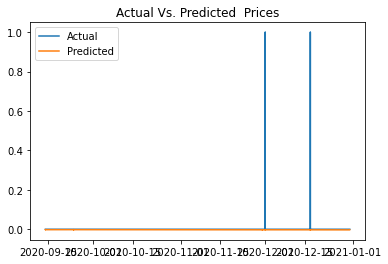

In [42]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted  Prices")